# Обнаружение болезни паркинсона с помощью XGBoost

Модель для предсказания ранних стадий болезни Паркинсона предназначена для использования в медицинских исследованиях и клинической практике с целью ранней диагностики заболевания. Это поможет врачам и исследователям своевременно выявлять заболевание и принимать меры для улучшения качества жизни пациентов.
Как работает модель:

1. Обработка данных:
      * Признаки из предоставленного набора данных [UCI ML Parkinsons](https://storage.yandexcloud.net/academy.ai/practica/parkinsons.data)(описание признаков и меток датасета представлены [здесь](https://storage.yandexcloud.net/academy.ai/practica/parkinsons.names)) нормализуются с использованием библиотеки sklearn для приведения их к единому масштабу, что улучшает работу алгоритма.
      * Данные делятся на обучающую (80%) и тестовую (20%) выборки.

2. Классификация:
      * Используется алгоритм XGBoost, известный своей высокой точностью и эффективностью. Он позволяет выявлять сложные зависимости между признаками и метками.

3. Обучение модели:
      * Модель обучается на предоставленном наборе данных, содержащем как признаки пациентов, так и метки, указывающие на наличие или отсутствие болезни Паркинсона.

4. Оценка точности:
      * После обучения модель тестируется на отложенной выборке для оценки точности. Целевой показатель — точность выше 95%, что подтверждает высокую эффективность модели.

Почему это важно:

Ранняя диагностика болезни Паркинсона имеет критическое значение для замедления прогрессирования заболевания. Данная модель может использоваться:

* В медицинских исследованиях для автоматизации диагностики.
* В клинических учреждениях для дополнительной поддержки врачей при постановке диагноза.
* В системах мониторинга здоровья для анализа биометрических данных пациентов.

Основные характеристики проекта:

* Использование передовых технологий, таких как XGBoost, для точной классификации.
* Обработка и нормализация данных с помощью sklearn.
* Высокая точность модели, превышающая 95%, что делает её надежным инструментом для практического применения.
* Пошаговая визуализация работы модели для удобного анализа и интерпретации.

Если при обучении модели в Google Colab возникает ошибка: "`__sklearn_tags__`", попробуйте использовать библиотеку scikit-learn версии 1.1

`!pip install scikit-learn==1.1`

In [1079]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [1080]:
# 1. Загрузка данных
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
data = pd.read_csv(url)

Разделение признаков и целевой переменной:

Признаки (X) включают все столбцы, кроме status (целевой переменной) и name (идентификатор пациента).

Целевая переменная (y) хранит информацию о наличии или отсутствии болезни Паркинсона.

In [1081]:
# 2. Разделение признаков и меток
X = data.drop(columns=['status', 'name'])  # Признаки
y = data['status']  # Целевая переменная

Посмотрим как распределены классы здоровых и больных пациентов.

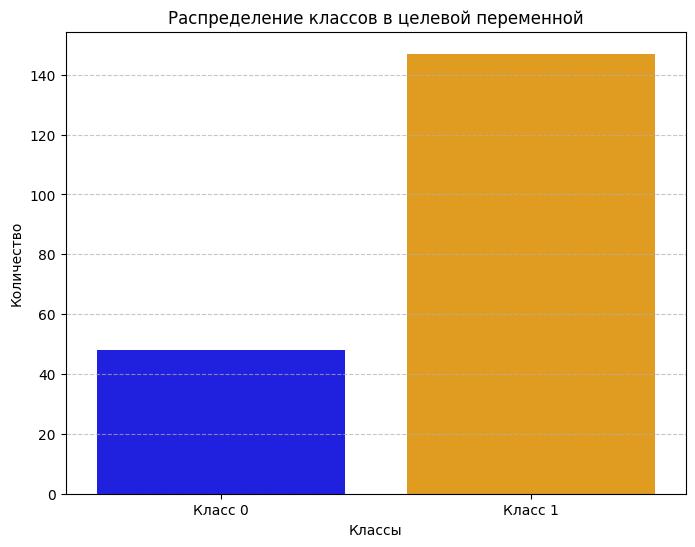

In [1082]:
# 3. Визуализация дисбаланса классов
plt.figure(figsize=(8, 6))
sns.countplot(x=y, hue=data['status'], palette=['blue', 'orange'], legend=False)
plt.title("Распределение классов в целевой переменной")
plt.xlabel("Классы")
plt.ylabel("Количество")
plt.xticks([0, 1], ['Класс 0', 'Класс 1'])  # Указываем подписи классов
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Оставляем 20% данных для тестовой выборки.

In [1083]:
# 4. Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Так как у нас дисбаланс классов, то мы применяем SMOTE для балансировки. Это поможет модели лучше обучиться.

In [1084]:
# 5. Балансировка классов с использованием SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Посмотрим на распределение классов после применения SMOTE

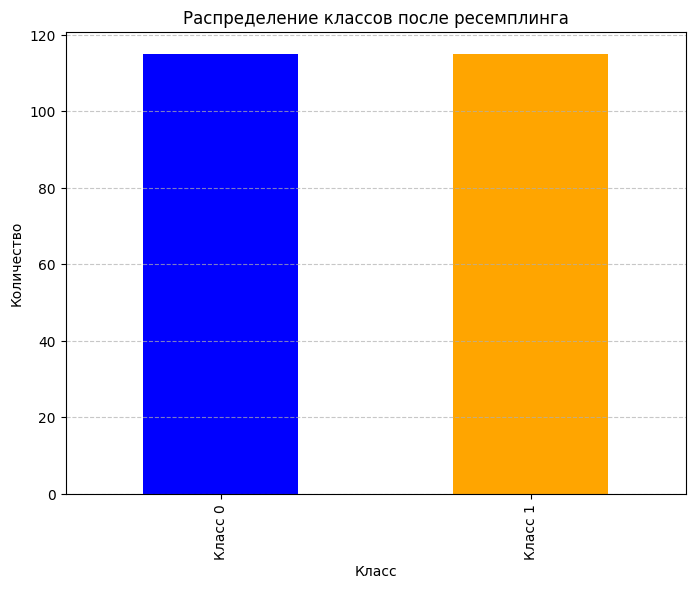

In [1085]:
# 6. Распределение классов после применения SMOTE
plt.figure(figsize=(8, 6))
resampled_counts = pd.Series(y_train_resampled).value_counts()
resampled_counts.plot(kind='bar', color=['blue', 'orange'])

plt.title("Распределение классов после ресемплинга")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.xticks([0, 1], ['Класс 0', 'Класс 1'])  # Указываем подписи классов
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [1086]:
# 7. Нормализация данных
scaler = Normalizer()
X_train_normalized = scaler.fit_transform(X_train_resampled)
X_test_normalized = scaler.transform(X_test)

Используем модель XGBoost с метрикой логарифмических потерь logloss.

In [1087]:
# 8. Модель XGBoost
model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

Для поиска оптимальных гиперпараметров используем метод GridSearchCV.

Так же сделаем вывод оптимальных гиперпараметров.

In [1088]:
start_time = time.time()

# 9. Оптимизация гиперпараметров с помощью GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_normalized, y_train_resampled)

# Лучшие параметры
best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Время обучения: {elapsed_time // 60:.0f} минут(а) {elapsed_time % 60:.0f} секунд(а)")

Лучшие параметры: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Время обучения: 0 минут(а) 35 секунд(а)


In [1089]:
# 10. Выбор модели с оптимальными параметрами
best_model = grid_search.best_estimator_

Использование кросс-валидации позволяет лучше оценить точность модели на разных подмножествах данных.

In [1090]:
# 11. Кросс-валидация
cv_scores = cross_val_score(best_model, X_train_normalized, y_train_resampled, cv=5, scoring='accuracy')
print(f"Средняя точность по кросс-валидации: {np.mean(cv_scores) * 100:.2f}%")

Средняя точность по кросс-валидации: 96.09%


In [1091]:
# 12. Предсказания на тестовых данных
y_pred = best_model.predict(X_test_normalized)
y_pred_proba = best_model.predict_proba(X_test_normalized)[:, 1]

Оценка модели:

Точность: процент правильно предсказанных значений на тестовой выборке.

ROC-AUC: метрика, показывающая способность модели разделять классы.

Отчет по классификации: включает показатели точности, полноты и F1-меры.

In [1092]:
# 13. Оценка модели
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Точность модели: {accuracy * 100:.2f}%")
print(f"ROC-AUC: {roc_auc:.2f}")

# Отчет по классификации
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred))

Точность модели: 87.18%
ROC-AUC: 0.94

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.94      0.91      0.92        32

    accuracy                           0.87        39
   macro avg       0.78      0.81      0.79        39
weighted avg       0.88      0.87      0.88        39



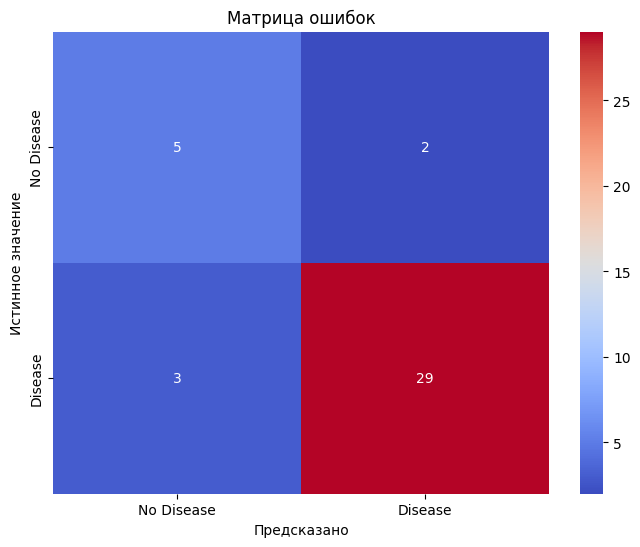

In [1093]:
# 14. Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Предсказано')
plt.ylabel('Истинное значение')
plt.title('Матрица ошибок')
plt.show()

ROC-кривая показывает производительность модели при различных порогах классификации. Это очень полезно для оценки качества модели, особенно при дисбалансе классов.

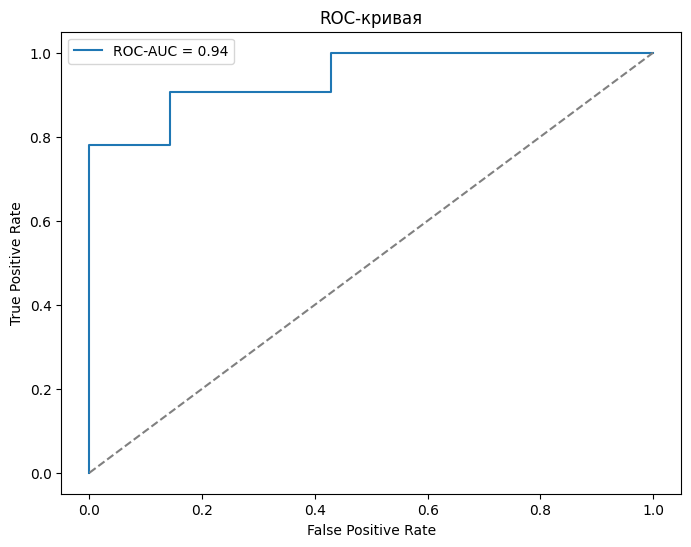

In [1094]:
# 15. Построение ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("ROC-кривая")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

PR-кривая полезна, когда классы сильно дисбалансированы. Она показывает точность и полноту при различных порогах классификации.

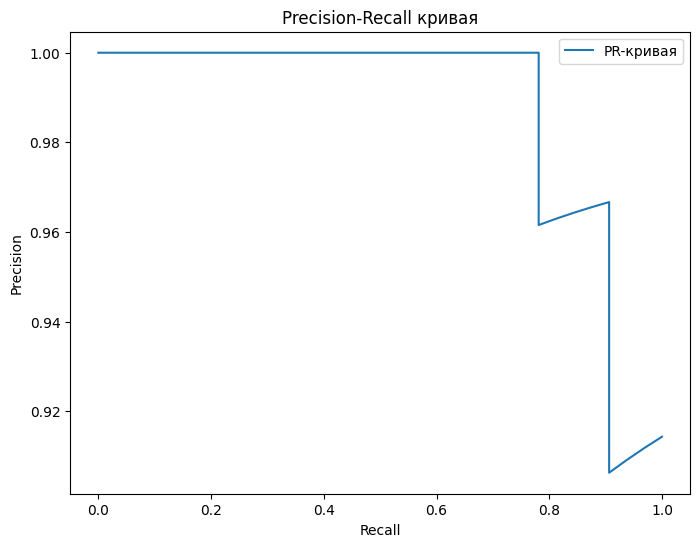

In [1095]:
# 16. Построение PR-кривой
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR-кривая")
plt.title("Precision-Recall кривая")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

Визуализация важности признаков:

plot_importance из XGBoost показывает, какие признаки наиболее важны для модели. Это помогает понять, какие параметры больше всего влияют на результат.

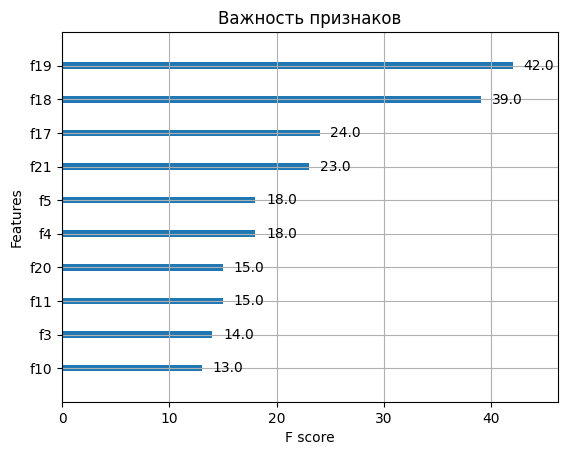

In [1096]:
# 17. Важность признаков
xgb.plot_importance(best_model, max_num_features=10)
plt.title("Важность признаков")
plt.show()

In [1097]:
# Примеры предсказаний
num_examples = 5  # Количество примеров для отображения
sample_indices = np.random.choice(range(X_test_normalized.shape[0]), size=num_examples, replace=False)

print("\nПримеры предсказаний модели:")
for i, idx in enumerate(sample_indices):
    print(f"\nПример {i + 1}:")
    print(f"Данные: {X_test_normalized[idx]}")
    print(f"Истинная метка: {y_test.iloc[idx]}")
    print(f"Предсказанная метка: {y_pred[idx]}")
    print(f"Вероятность предсказания (положительный класс): {y_pred_proba[idx]:.2f}")


Примеры предсказаний модели:

Пример 1:
Данные: [ 5.60691713e-01  6.20981254e-01  5.31823234e-01  2.61335710e-05
  2.53232277e-07  1.40290681e-05  1.46368256e-05  4.20872044e-05
  1.12181899e-04  1.04331698e-03  6.50300487e-05  6.17380291e-05
  8.68586709e-05  1.95039500e-04  2.39051269e-05  1.27613874e-01
  2.34753411e-03  4.08826797e-03 -2.77420619e-02  1.59573813e-03
  9.43083593e-03  1.15789952e-03]
Истинная метка: 1
Предсказанная метка: 1
Вероятность предсказания (положительный класс): 0.95

Пример 2:
Данные: [ 6.45361231e-01  6.85001364e-01  3.24943887e-01  1.62056197e-05
  1.27269265e-07  8.10280986e-06  9.58761795e-06  2.43508527e-05
  2.51356798e-04  2.70235072e-03  1.41735538e-04  1.60953197e-04
  1.86576742e-04  4.25249037e-04  5.13743599e-05  8.89569738e-02
  1.89824654e-03  2.96024068e-03 -2.61010214e-02  7.36125428e-04
  8.82451568e-03  6.82201440e-04]
Истинная метка: 1
Предсказанная метка: 1
Вероятность предсказания (положительный класс): 0.99

Пример 3:
Данные: [ 5.735